In [461]:
# Data manipulation
import pandas as pd
import numpy as np
import random

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mean_squared_error

# Utilities
from itertools import product


In [462]:
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# NO  STATUS REGION SUBREGION

In [463]:
'''



#df2 = pd.read_csv(r'E:\Tesis\Data\raw3.csv', delimiter=';', engine='python')
df2 = pd.read_csv(r'E:\bridge_cause_analysis\Data\raw4.csv', encoding='latin-1')
df2


# %%
df2.rename(columns={
    "SSP1-1.9": "temperature_1.9",
    "SSP1-1.9.1": "temperature_1.9.1",  
    "SSP2-4.5": "temperature_4.5",
    "SSP3-7.0": "temperature_7.0",
    "SSP5-8.5": "temperature_8.5"
}, inplace=True)

# %%
df2.info()

# %%
def compare_not_defined_frequency(df, column_name):
    is_not_defined = df[column_name] == "Not defined"
    
    counts = {
        "Not defined": is_not_defined.sum(),
        "Defined": (~is_not_defined).sum()
    }

    count_series = pd.Series(counts)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=count_series.index, y=count_series.values, palette="pastel")
    plt.title(f"'Not defined' vs Defined values in '{column_name}'")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




def stacked_not_defined_comparison(df, columns_to_check):
    # Etiquetas legibles para las temperaturas
    pretty_labels = {
        "temperature_1.9": "SSP1-1.9",
        "temperature_1.9.1": "SSP1-1.9.1",
        "temperature_4.5": "SSP2-4.5",
        "temperature_7.0": "SSP3-7.0",
        "temperature_8.5": "SSP5-8.5",
    }

    data = {
        "Variable": [],
        "Category": [],
        "Count": []
    }

    for col in columns_to_check:
        col_series = df[col]
        
        if pd.api.types.is_numeric_dtype(col_series):
            not_defined_count = col_series.isna().sum()
        else:
            col_series = col_series.astype(str).str.strip()
            not_defined_count = col_series.isin(["Not defined", "No definido", "#N/A", "ER"]).sum() + col_series.isna().sum()

        defined_count = df.shape[0] - not_defined_count

        data["Variable"].extend([col, col])
        data["Category"].extend(["No definido", "Definido"])
        data["Count"].extend([not_defined_count, defined_count])

    plot_df = pd.DataFrame(data)

    pivot_df = plot_df.pivot(index="Variable", columns="Category", values="Count").fillna(0)

    for cat in ["No definido", "Definido"]:
        if cat not in pivot_df.columns:
            pivot_df[cat] = 0
    pivot_df = pivot_df[["No definido", "Definido"]]

    # Cambiar nombres por etiquetas legibles
    pivot_df = pivot_df.rename(index=pretty_labels)

    # Graficar
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), color=["salmon", "lightgreen"])
    plt.title("Valores Definidos vs No definidos por variable")
    plt.ylabel("Cantidad")
    plt.xlabel("Variable")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Categoría")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    for i, variable in enumerate(pivot_df.index):
        total = pivot_df.loc[variable].sum()
        y_offset = 0
        for category in pivot_df.columns:
            value = pivot_df.loc[variable, category]
            if value > 0:
                percent = (value / total) * 100
                ax.text(i, y_offset + value / 2, f"{percent:.1f}%", ha='center', va='center',
                        fontsize=9, color='black', fontweight='bold')
                y_offset += value

    plt.tight_layout()
    plt.show()


# %%
cat_cols=['Type','Cause','Material','Collapse','Status','Country','Region']

num_cols = [
    'Date',
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]



df2=df2.dropna()
df2=df2.drop(columns=['Name','Sub-region'])

target=['Cause']

features=cat_cols+num_cols
X=df2[features].copy()


stacked_not_defined_comparison(X, features)


# %%
X = X[
    (X['Type'] != "Not defined") &
    (X['Material'] != "Not defined") &
    (X['Cause'] != "No definido") &
    (X['Date'] != 'No date') &
    (X['Date'] != 'no date') &
    (X['temperature_1.9'] != "ER") &
    (X['temperature_1.9'] != "#N/A") &
    (X['temperature_1.9.1'] != "ER") &
    (X['temperature_1.9.1'] != "#N/A") &
    (X['temperature_4.5'] != "ER") &
    (X['temperature_4.5'] != "#N/A") &
    (X['temperature_7.0'] != "ER") &
    (X['temperature_7.0'] != "#N/A") &
    (X['temperature_8.5'] != "ER") &
    (X['temperature_8.5'] != "#N/A")
]


X['Date']=pd.to_datetime(X['Date'],errors='coerce').dt.year
X=X.dropna(subset=['Date'])




# %%
stacked_not_defined_comparison(X, features)

# %%
len(X)

# %%
temperature_columns = [
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]

for col in temperature_columns:
    X[col] = (
        X[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace(r'[^\d\.\-]', '', regex=True)
        .str.strip()
    )

X[temperature_columns] = X[temperature_columns].apply(pd.to_numeric, errors='coerce')


# %% [markdown]
# # Frecuencias
# 

# %%
df=X

# %%
plt.figure(figsize=(10,6))
sns.histplot(df['Date'].dropna(), bins=30, kde=False)
plt.xlabel('Año de colapso')
plt.ylabel('Numero de colapsos')
plt.title('Histograma de colapsos por año')
plt.grid(True)
plt.show()


# %%

def plot_top_values(df, column, n=None):
    if n is None:
        values = df[column].value_counts()
    else:
        values = df[column].value_counts().head(n)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(values.index, values.values, color='steelblue')
    
    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
            height,                             # y position (top of bar)
            str(height),                        # text
            ha='center', va='bottom', fontsize=9
        )
    
    plt.title('Top ' + (str(n) if n else 'all') + ' ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# %%
temp_cat_cols=cat_cols.copy()
temp_cat_cols.append("Cause")

for column in cat_cols:
    plot_top_values(df,column)


# %%

country_counts = df['Country'].value_counts()
country_counts.plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')
plt.title('Bridge Collapses by Country')
plt.ylabel('')
plt.show()

# %% [markdown]
# # Eliminacion de Outliers

# %%

temp_df=X

## Eliminacion de Causes que tienen pocos valores

X = X[~X['Cause'].isin(["Ciclon", "Huricane", "Terrorism", "Deterioration",'Earthquake'])]



Y=X['Cause'].copy()

cat_cols.remove("Country")
cat_cols.remove("Region")
cat_cols.remove("Status")

temp_df=X


# %%
print("Count de X "+str(X.count()))

# %%
X.info()

# %%
temp_df

# %%
temp_df.info()

# %%

def plot_boxplots_for_floats(df):
    float_cols = df.select_dtypes(include='float').columns

    for col in float_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Cause', y=col)
        plt.xticks(rotation=45)
        plt.title(f'Boxplot of {col} grouped by Cause')
        plt.tight_layout()
        plt.show()


# %%
plot_boxplots_for_floats(temp_df)


# %%
def get_outlier_indices(df, cols):
    outlier_indices = set()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get indices of outliers in this column
        outliers_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers_col)
    return outlier_indices

def remove_outliers(df):
    float_cols = df.select_dtypes(include='float').columns
    outlier_indices = get_outlier_indices(df, float_cols)
    print(f"Removing {len(outlier_indices)} rows identified as outliers.")
    return df.drop(index=outlier_indices)

temp_df = remove_outliers(temp_df)

root_df=temp_df

temp_df=temp_df.drop(columns=['Region','Country','Status','Date','Collapse'])
#temp_df=temp_df.drop(columns=['Region','Status','Date','Collapse'])

'''

'\n\n\n\n#df2 = pd.read_csv(r\'E:\\Tesis\\Data\raw3.csv\', delimiter=\';\', engine=\'python\')\ndf2 = pd.read_csv(r\'E:\x08ridge_cause_analysis\\Data\raw4.csv\', encoding=\'latin-1\')\ndf2\n\n\n# %%\ndf2.rename(columns={\n    "SSP1-1.9": "temperature_1.9",\n    "SSP1-1.9.1": "temperature_1.9.1",  \n    "SSP2-4.5": "temperature_4.5",\n    "SSP3-7.0": "temperature_7.0",\n    "SSP5-8.5": "temperature_8.5"\n}, inplace=True)\n\n# %%\ndf2.info()\n\n# %%\ndef compare_not_defined_frequency(df, column_name):\n    is_not_defined = df[column_name] == "Not defined"\n    \n    counts = {\n        "Not defined": is_not_defined.sum(),\n        "Defined": (~is_not_defined).sum()\n    }\n\n    count_series = pd.Series(counts)\n\n    plt.figure(figsize=(6, 4))\n    sns.barplot(x=count_series.index, y=count_series.values, palette="pastel")\n    plt.title(f"\'Not defined\' vs Defined values in \'{column_name}\'")\n    plt.ylabel("Count")\n    plt.xlabel("Category")\n    plt.grid(True, axis=\'y\', linestyl

In [464]:
temp_df=pd.read_csv(r'E:\bridge_cause_analysis\Data\no_supervised_data.csv')
root_df=temp_df
root_df

,Type,Cause,Material,Collapse,Status,Country,Region,Date,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5
0,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1966,-0.36346,-0.306055,-0.24865,-0.225425,-0.24865
1,Truss,Collision events,Steel,Total,Operational,Germany,Europe,2015,0.96894,1.784090,1.65721,1.445855,1.41198
2,Truss,Collision events,Steel,Partial,Operational,Germany,Europe,1869,0.40503,0.348125,0.21938,0.244370,0.21938
3,Suspension,Collision events,Wood,Partial,Operational,Germany,Europe,1908,-0.37668,0.055205,-0.03791,-0.281860,-0.05782
4,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1979,-0.01883,0.183450,0.26149,0.136105,0.11345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Beam,Construction deficiencies,Reinforced concrete,Total,Construction,Jordan,Asia,2003,1.06424,0.899050,1.01453,1.045700,1.01453
820,Beam,Flood,Composite,Partial,Operational,Lesotho,Africa,2020,1.67965,1.289420,1.18791,1.369190,1.30962
821,Beam,Flood,Reinforced concrete,Total,Operational,Liberia,Africa,2025,1.57352,1.523960,1.32506,1.351885,1.60314
822,Beam,Construction deficiencies,Composite,Total,Operational,Mexico,North America,2022,1.42284,1.466040,1.65549,1.288590,1.42562


# AutoEncoder

In [465]:
# Original columns
columns = list(temp_df.columns)

exclude_cols = ['Date','Type','Cause','Material','Collapse','Status','Country','Region']

num_cols = [col for col in columns if col not in exclude_cols]


print("Numeric columns:", num_cols)


Numeric columns: ['temperature_1.9', 'temperature_1.9.1', 'temperature_4.5', 'temperature_7.0', 'temperature_8.5']


In [466]:
cat_cols = ['Type','Cause','Material']


In [467]:
temp_df

,Type,Cause,Material,Collapse,Status,Country,Region,Date,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5
0,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1966,-0.36346,-0.306055,-0.24865,-0.225425,-0.24865
1,Truss,Collision events,Steel,Total,Operational,Germany,Europe,2015,0.96894,1.784090,1.65721,1.445855,1.41198
2,Truss,Collision events,Steel,Partial,Operational,Germany,Europe,1869,0.40503,0.348125,0.21938,0.244370,0.21938
3,Suspension,Collision events,Wood,Partial,Operational,Germany,Europe,1908,-0.37668,0.055205,-0.03791,-0.281860,-0.05782
4,Beam,Collision events,Reinforced concrete,Total,Operational,Germany,Europe,1979,-0.01883,0.183450,0.26149,0.136105,0.11345
...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,Beam,Construction deficiencies,Reinforced concrete,Total,Construction,Jordan,Asia,2003,1.06424,0.899050,1.01453,1.045700,1.01453
820,Beam,Flood,Composite,Partial,Operational,Lesotho,Africa,2020,1.67965,1.289420,1.18791,1.369190,1.30962
821,Beam,Flood,Reinforced concrete,Total,Operational,Liberia,Africa,2025,1.57352,1.523960,1.32506,1.351885,1.60314
822,Beam,Construction deficiencies,Composite,Total,Operational,Mexico,North America,2022,1.42284,1.466040,1.65549,1.288590,1.42562


#### Ordinal

In [468]:



encoder = OrdinalEncoder()

X_encoded = encoder.fit_transform(temp_df[cat_cols])


# %%
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols), index=temp_df.index)
X_encoded_df

X_encoded_df = pd.concat(
    [temp_df.drop(columns=cat_cols), X_encoded_df],
    axis=1
)




In [469]:
X_encoded_df=X_encoded_df[num_cols+cat_cols]
X_encoded_df

,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5,Type,Cause,Material
0,-0.36346,-0.306055,-0.24865,-0.225425,-0.24865,1.0,0.0,5.0
1,0.96894,1.784090,1.65721,1.445855,1.41198,6.0,0.0,7.0
2,0.40503,0.348125,0.21938,0.244370,0.21938,6.0,0.0,7.0
3,-0.37668,0.055205,-0.03791,-0.281860,-0.05782,4.0,0.0,8.0
4,-0.01883,0.183450,0.26149,0.136105,0.11345,1.0,0.0,5.0
...,...,...,...,...,...,...,...,...
819,1.06424,0.899050,1.01453,1.045700,1.01453,1.0,1.0,5.0
820,1.67965,1.289420,1.18791,1.369190,1.30962,1.0,4.0,1.0
821,1.57352,1.523960,1.32506,1.351885,1.60314,1.0,4.0,5.0
822,1.42284,1.466040,1.65549,1.288590,1.42562,1.0,1.0,1.0


In [470]:
X_train, X_val = train_test_split(X_encoded_df, test_size=0.2, random_state=SEED)


### BEST MODEL MSE LOSS

In [471]:


# def run_autoencoder_once(X_train, X_val, latent_dims=[3,4,5,6,10,15,20]):
#     input_dim = X_train.shape[1]
#     val_losses = {}

#     for dim in latent_dims:
#         input_layer = layers.Input(shape=(input_dim,))
#         x = layers.Dense(8, activation='relu',
#                          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))(input_layer)
#         latent = layers.Dense(dim, activation='relu',
#                               activity_regularizer=regularizers.l1(1e-4),
#                               kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))(x)
#         x = layers.Dense(8, activation='relu',
#                          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))(latent)
#         output_layer = layers.Dense(input_dim, activation='linear',
#                                     kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED))(x)

#         autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
#         autoencoder.compile(optimizer='adam', loss='mse')

#         history = autoencoder.fit(
#             X_train, X_train,
#             validation_data=(X_val, X_val),
#             epochs=100,
#             batch_size=32,
#             shuffle=False,
#             verbose=0
#         )

#         val_losses[dim] = history.history['val_loss'][-1]

#     best_dim = min(val_losses, key=val_losses.get)
#     return best_dim, val_losses

# N_RUNS = 10
# latent_dims = [3,4,5,6,7]

# best_dims_across_runs = []
# all_losses_across_runs = {dim: [] for dim in latent_dims}

# for i in range(N_RUNS):
#     print(f"=== RUN {i+1} of {N_RUNS} ===")
#     best_dim, losses = run_autoencoder_once(X_train, X_val, latent_dims)
#     best_dims_across_runs.append(best_dim)
#     for dim in latent_dims:
#         all_losses_across_runs[dim].append(losses[dim])

# print("\n=== AVERAGE VALIDATION LOSS PER DIM ===")
# for dim in latent_dims:
#     avg = np.mean(all_losses_across_runs[dim])
#     print(f"Dim {dim}: avg val_loss = {avg:.6f}")


### FIRST GOOD

Latent dim = 3, Validation Loss final = 0.604496
Latent dim = 4, Validation Loss final = 0.247889
Latent dim = 5, Validation Loss final = 0.059175
Latent dim = 6, Validation Loss final = 0.244826
Latent dim = 7, Validation Loss final = 0.059852


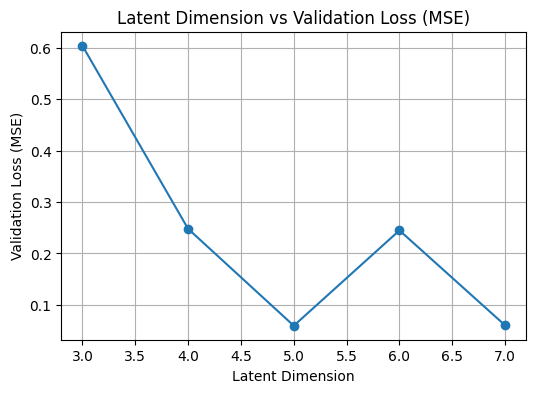


Best latent dim: 5


In [472]:


latent_dims = [ 3,4, 5,6, 7]
val_losses_final = []

input_dim = X_train.shape[1]

best_val_loss = float('inf')
best_model = None
best_latent_dim = None
best_history = None

all_models = {}
all_histories = {}

for dim in latent_dims:

    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    input_layer = layers.Input(shape=(input_dim,))
    x = layers.Dense(8, activation='relu')(input_layer)
    latent = layers.Dense(
        dim, activation='relu',
        activity_regularizer=regularizers.l1(1e-4)
    )(x)
    x = layers.Dense(8, activation='relu')(latent)
    output_layer = layers.Dense(input_dim, activation='linear')(x)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train
    history = autoencoder.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=100,
        batch_size=32,
        shuffle=True,
        verbose=0
    )

    # Save final val_loss 
    val_loss_final = history.history['val_loss'][-1]
    val_losses_final.append(val_loss_final)

    print(f"Latent dim = {dim}, Validation Loss final = {val_loss_final:.6f}")

    # Save model + history
    all_models[dim] = autoencoder
    all_histories[dim] = history

    if val_loss_final < best_val_loss:
        best_val_loss = val_loss_final
        best_latent_dim = dim
        best_model = autoencoder
        best_history = history

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_losses_final, marker='o')
plt.title("Latent Dimension vs Validation Loss (MSE)")
plt.xlabel("Latent Dimension")
plt.ylabel("Validation Loss (MSE)")
plt.grid(True)
plt.show()

print("\nBest latent dim:", best_latent_dim)


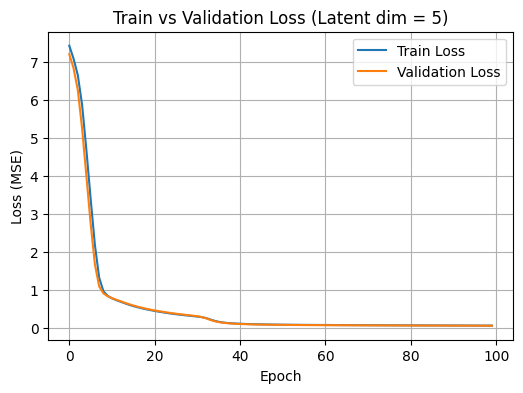

In [473]:
plt.figure(figsize=(6,4))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f"Train vs Validation Loss (Latent dim = {best_latent_dim})")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [474]:
def extract_encoder_from_autoencoder(autoencoder, latent_dim):
    encoder = models.Model(
        inputs=autoencoder.input, 
        outputs=autoencoder.layers[2].output  
    )
    return encoder


In [475]:
print("Best Latent_DIM: "+str(best_latent_dim))

Best Latent_DIM: 5


In [476]:
dim=best_latent_dim
autoencoder = all_models[dim]
encoder = extract_encoder_from_autoencoder(autoencoder, 3)

Z_dim = encoder.predict(X_encoded_df)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# TSNE

In [477]:

def plot_tsne(Z, labels, title="t-SNE - Latent Dimension"):
    """
    Aplica t-SNE a Z y lo grafica coloreado según labels.
    
    Parámetros:
    -----------
    Z : np.array
        Representación latente generada por el encoder.
    labels : array-like
        Column con las etiquetas (por ejemplo temp_df["Cause"]).
    title : str
        Título del gráfico.
    """
    
    # Convertir etiquetas a números
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)

    # Aplicar t-SNE
    Z_tsne = TSNE(n_components=2, random_state=42).fit_transform(Z)

    # Graficar
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1],
                          c=y_encoded, cmap='viridis', alpha=0.6)

    # Leyenda
    handles, _ = scatter.legend_elements()
    legend_labels = le.inverse_transform(range(len(handles)))

    plt.legend(handles, legend_labels, title="Cause",
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


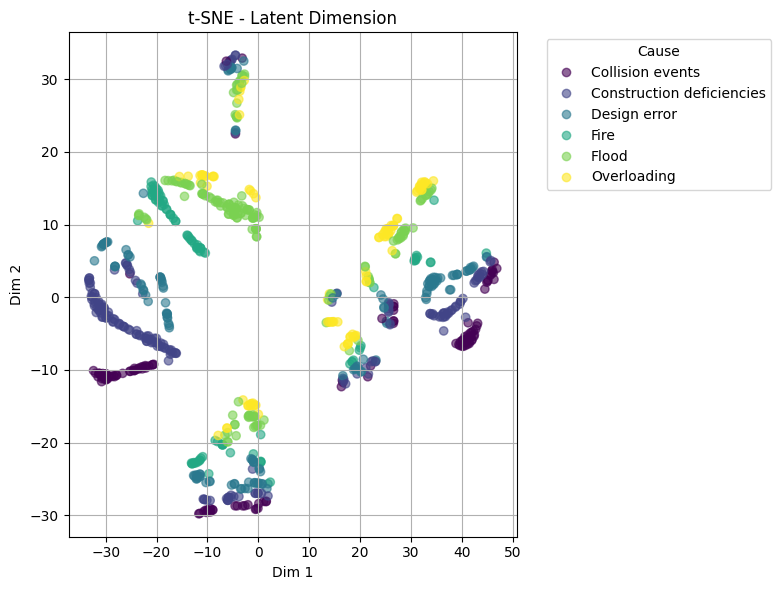

In [478]:

plot_tsne(Z_dim, temp_df["Cause"])


In [479]:
#Saving Z 

np.save("Z_latent.npy", Z_dim)

In [480]:
X=pd.read_csv(r"E:\bridge_cause_analysis\Data\X.csv")

In [481]:
#encodificacion

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    #('scale', StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)

X_processed= X_processed.toarray()

In [482]:

def autoencoder_best_dim(X_train, X_val, latent_dims=[3,4,5,6,7,8], iterations=10, epochs=100, batch_size=32):
    """
    Trains autoencoders for multiple latent dimensions multiple times,
    and returns the average best latent dimension based on validation loss.
    """
    best_dims = []

    input_dim = X_train.shape[1]

    for it in range(iterations):
        val_losses_final = []
        best_val_loss = float('inf')
        best_latent_dim = None

        for dim in latent_dims:
            # Build autoencoder
            input_layer = layers.Input(shape=(input_dim,))
            x = layers.Dense(8, activation='relu')(input_layer)
            latent = layers.Dense(dim, activation='relu', activity_regularizer=regularizers.l1(1e-4))(x)
            x = layers.Dense(8, activation='relu')(latent)
            output_layer = layers.Dense(input_dim, activation='linear')(x)

            autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
            autoencoder.compile(optimizer='adam', loss='mse')

            # Train
            history = autoencoder.fit(
                X_train, X_train,
                validation_data=(X_val, X_val),
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose=0
            )

            val_loss_final = history.history['val_loss'][-1]
            val_losses_final.append(val_loss_final)

            if val_loss_final < best_val_loss:
                best_val_loss = val_loss_final
                best_latent_dim = dim

        best_dims.append(best_latent_dim)

    avg_best_dim = np.mean(best_dims)
    print(f"Best latent dimension per iteration: {best_dims}")
    print(f"Average best latent dimension: {avg_best_dim:.2f}")

    # Optional: plot the last iteration's val_losses
    plt.figure(figsize=(6,4))
    plt.plot(latent_dims, val_losses_final, marker='o')
    plt.title("Latent Dimension vs Validation Loss (Last Iteration)")
    plt.xlabel("Latent Dimension")
    plt.ylabel("Validation Loss (MSE)")
    plt.grid(True)
    plt.show()

    return avg_best_dim, best_dims


# GRID SEARCH TESTING

In [483]:

def optimize_clustering(X, cluster_range=[2,3,4,5]):
    param_grid = {
        "KMeans": {"n_init": [10, 20, 30, 40], "max_iter": [300, 600]},
        "Agglomerative": {"linkage": ["ward", "average", "complete"], "metric": ["euclidean"]},
        "Spectral": {"affinity": ["nearest_neighbors", "rbf"], "assign_labels": ["kmeans", "discretize"]},
        "GaussianMixture": {"covariance_type": ["full", "tied", "diag", "spherical"]}
    }

    results = []

    for k in cluster_range:
        for model_name in ["KMeans", "Agglomerative", "Spectral", "GaussianMixture"]:
            grid = param_grid[model_name]
            
            for params in (dict(zip(grid.keys(), values)) for values in product(*grid.values())):
                try:
                    # -----------------------------
                    # Build model
                    # -----------------------------
                    if model_name == "KMeans":
                        model = KMeans(n_clusters=k, random_state=42, **params)

                    elif model_name == "Agglomerative":
                        linkage = params["linkage"]
                        if linkage == "ward":
                            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
                        else:
                            model = AgglomerativeClustering(
                                n_clusters=k, linkage=linkage, metric=params["metric"]
                            )

                    elif model_name == "Spectral":
                        model = SpectralClustering(
                            n_clusters=k, random_state=42, **params
                        )

                    elif model_name == "GaussianMixture":
                        model = GaussianMixture(
                            n_components=k, random_state=42, **params
                        )

                    # -----------------------------
                    # Fit / Predict
                    # -----------------------------
                    if model_name == "GaussianMixture":
                        model.fit(X)
                        labels = model.predict(X)
                        inertia = None
                        aic = model.aic(X)
                        bic = model.bic(X)

                    elif model_name == "KMeans":
                        model.fit(X)
                        labels = model.labels_
                        inertia = model.inertia_
                        aic = None
                        bic = None

                    else:
                        labels = model.fit_predict(X)
                        inertia = None
                        aic = None
                        bic = None

                    # -----------------------------
                    # Metrics
                    # -----------------------------
                    try:
                        sil = silhouette_score(X, labels)
                    except:
                        sil = np.nan

                    try:
                        db = davies_bouldin_score(X, labels)
                    except:
                        db = np.nan

                    try:
                        ch = calinski_harabasz_score(X, labels)
                    except:
                        ch = np.nan

                    # -----------------------------
                    # Store results
                    # -----------------------------
                    row = {
                        "Model": model_name,
                        "Clusters": k,
                        "Params": params,
                        "Labels": labels,
                        "Inertia": inertia,   # used for KMeans elbow
                        "AIC": aic,            # for GMM elbow
                        "BIC": bic,            # for GMM elbow
                        "Silhouette": sil,
                        "DB": db,
                        "CH": ch,
                        "TrainedModel": model
                    }

                    results.append(row)

                except Exception as e:
                    print(f"⚠ Error: {model_name}, k={k}, params={params}: {e}")

    return pd.DataFrame(results)


In [484]:
df_raw=optimize_clustering(Z_dim, cluster_range=[2, 3, 4, 5,6])
df_raw

,Model,Clusters,Params,Labels,Inertia,AIC,BIC,Silhouette,DB,CH,TrainedModel
0,KMeans,2,"{'n_init': 10, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=10, random_state=42)"
1,KMeans,2,"{'n_init': 10, 'max_iter': 600}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(max_iter=600, n_clusters=2, n_init=10, ..."
2,KMeans,2,"{'n_init': 20, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=20, random_state=42)"
3,KMeans,2,"{'n_init': 20, 'max_iter': 600}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(max_iter=600, n_clusters=2, n_init=20, ..."
4,KMeans,2,"{'n_init': 30, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=30, random_state=42)"
...,...,...,...,...,...,...,...,...,...,...,...
90,Spectral,6,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[0, 5, 5, 5, 0, 0, 0, 1, 0, 0, 5, 5, 5, 0, 0, ...",NaN,NaN,NaN,0.349308,1.117167,647.687683,"SpectralClustering(assign_labels='discretize',..."
91,GaussianMixture,6,{'covariance_type': 'full'},"[1, 2, 2, 3, 1, 1, 1, 0, 0, 1, 2, 2, 2, 5, 5, ...",NaN,27.000780,616.272096,0.112444,1.830788,498.755615,"GaussianMixture(n_components=6, random_state=42)"
92,GaussianMixture,6,{'covariance_type': 'tied'},"[5, 2, 2, 0, 5, 5, 5, 0, 5, 5, 2, 2, 2, 4, 4, ...",NaN,4397.041605,4632.750132,0.245456,2.398902,545.189148,"GaussianMixture(covariance_type='tied', n_comp..."
93,GaussianMixture,6,{'covariance_type': 'diag'},"[5, 2, 2, 3, 5, 5, 5, 0, 5, 5, 2, 2, 2, 5, 5, ...",NaN,8490.139735,8796.560819,0.262334,1.262180,752.325073,"GaussianMixture(covariance_type='diag', n_comp..."


# Elbow

In [485]:


def elbow_kmeans(df):
    df_kmeans = df[df["Model"] == "KMeans"]

    inertia_data = (
        df_kmeans.groupby("Clusters")["Inertia"]
        .mean()
        .sort_index()
    )

    ks = inertia_data.index.values
    inertia_vals = inertia_data.values

    # Compute first and second derivatives
    delta = np.diff(inertia_vals)
    delta2 = np.diff(delta)

    # Elbow = index of maximum curvature (min second derivative)
    elbow_idx = np.argmin(delta2) + 1  
    best_k = ks[elbow_idx]

    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(ks, inertia_vals, marker='o')
    plt.title("KMeans Elbow Method")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.axvline(best_k, color='r', linestyle='--', label=f"Elbow k={best_k}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_k


In [486]:
def elbow_gmm(df):
    df_gmm = df[df["Model"] == "GaussianMixture"]

    bic_data = (
        df_gmm.groupby("Clusters")["BIC"]
        .mean()
        .sort_index()
    )

    ks = bic_data.index.values
    bic_vals = bic_data.values

    # First + second derivatives
    delta = np.diff(bic_vals)
    delta2 = np.diff(delta)

    elbow_idx = np.argmax(delta2) + 1  
    best_k = ks[elbow_idx]

    plt.figure(figsize=(6,4))
    plt.plot(ks, bic_vals, marker='o')
    plt.title("Gaussian Mixture BIC Elbow")
    plt.xlabel("K")
    plt.ylabel("BIC")
    plt.axvline(best_k, color='r', linestyle='--', label=f"BIC elbow k={best_k}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_k


In [487]:


def compute_best_models_by_silhouette(df):
    """
    Selects the best model for each clustering algorithm based on Silhouette score.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns including 'Model' and 'Silhouette'.
    
    Returns
    -------
    pd.DataFrame
        Best model per algorithm based on Silhouette score.
    """
    best_models = []

    for model_name in df["Model"].unique():
        subset = df[df["Model"] == model_name].copy()

        # Skip if all silhouettes are NaN
        if subset["Silhouette"].notna().sum() == 0:
            continue

        # Pick row with max Silhouette
        best_row = subset.loc[subset["Silhouette"].idxmax()]
        best_models.append(best_row)

    return pd.DataFrame(best_models).reset_index(drop=True)


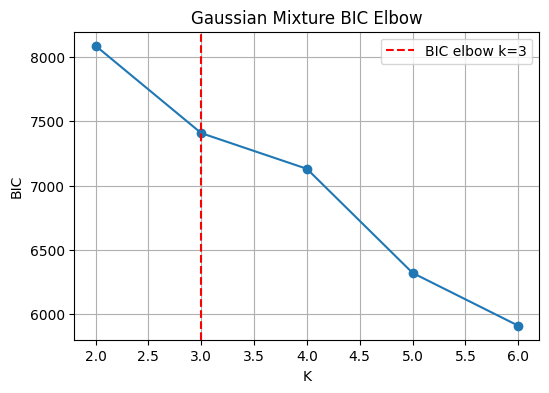

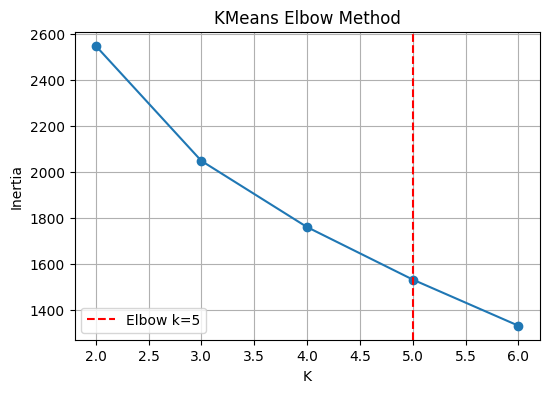

In [488]:
best_k_gaussian=elbow_gmm(df_raw)
best_k_kmeans=elbow_kmeans(df_raw)



In [489]:

def compute_weighted_best_models(df,
                                 w_sil=0.7,
                                 w_ch=0.15,
                                 w_db=0.15):
    """
    Computes a weighted score for each clustering model using:
    - Silhouette (higher is better)
    - Davies-Bouldin DB (lower is better)
    - Calinski-Harabasz CH (higher is better)

    Silhouette weight must be > 0.50 as requested.
    """

    df = df.copy()

    # --- Normalize Silhouette (higher = better) ---
    df["Sil_norm"] = (
        (df["Silhouette"] - df["Silhouette"].min()) /
        (df["Silhouette"].max() - df["Silhouette"].min())
    )

    # --- Normalize CH (higher = better) ---
    df["CH_norm"] = (
        (df["CH"] - df["CH"].min()) /
        (df["CH"].max() - df["CH"].min())
    )

    # --- Normalize DB (lower = better → invert) ---
    df["DB_norm"] = 1 - (
        (df["DB"] - df["DB"].min()) /
        (df["DB"].max() - df["DB"].min())
    )

    # --- Weighted Score ---
    df["WeightedScore"] = (
        w_sil * df["Sil_norm"] +
        w_ch  * df["CH_norm"] +
        w_db  * df["DB_norm"]
    )

    # Select best row per Model name
    best_models = (
        df.loc[df.groupby("Model")["WeightedScore"].idxmax()]
          .reset_index(drop=True)
    )

    return best_models


In [490]:
df_best_weighted=compute_weighted_best_models(df_raw)
df_best_weighted

,Model,Clusters,Params,Labels,Inertia,AIC,BIC,Silhouette,DB,CH,TrainedModel,Sil_norm,CH_norm,DB_norm,WeightedScore
0,Agglomerative,2,"{'linkage': 'ward', 'metric': 'euclidean'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.609271,0.574813,1845.850586,AgglomerativeClustering(),0.995737,0.985361,0.996961,0.994364
1,GaussianMixture,2,{'covariance_type': 'spherical'},"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,10773.625376,10834.909593,0.612310,0.569253,1865.189819,"GaussianMixture(covariance_type='spherical', n...",1.000000,0.995851,1.000000,0.999378
2,KMeans,2,"{'n_init': 10, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=10, random_state=42)",0.999732,1.000000,0.996896,0.999347
3,Spectral,2,"{'affinity': 'rbf', 'assign_labels': 'kmeans'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.607776,0.597126,1845.589844,"SpectralClustering(n_clusters=2, random_state=42)",0.993640,0.985220,0.984766,0.991046


In [491]:
df_best=compute_best_models_by_silhouette(df_raw)
df_best

,Model,Clusters,Params,Labels,Inertia,AIC,BIC,Silhouette,DB,CH,TrainedModel
0,KMeans,2,"{'n_init': 10, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=10, random_state=42)"
1,Agglomerative,2,"{'linkage': 'ward', 'metric': 'euclidean'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.609271,0.574813,1845.850586,AgglomerativeClustering()
2,Spectral,2,"{'affinity': 'rbf', 'assign_labels': 'kmeans'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.607776,0.597126,1845.589844,"SpectralClustering(n_clusters=2, random_state=42)"
3,GaussianMixture,2,{'covariance_type': 'spherical'},"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,10773.625376,10834.909593,0.612310,0.569253,1865.189819,"GaussianMixture(covariance_type='spherical', n..."


In [492]:
df_best[['Model', 'Silhouette', 'DB','CH', 'Clusters']]


,Model,Silhouette,DB,CH,Clusters
0,KMeans,0.612119,0.574932,1872.838013,2
1,Agglomerative,0.609271,0.574813,1845.850586,2
2,Spectral,0.607776,0.597126,1845.589844,2
3,GaussianMixture,0.612310,0.569253,1865.189819,2


In [493]:
def compute_best_models_weights(df):
    df = df.copy()
    best_models = []

    for k in df["Clusters"].unique():
        subset = df[df["Clusters"] == k].copy()

        for metric in ["Silhouette", "DB", "CH", "Inertia"]:
            vals = subset[metric]
            if vals.notna().sum() > 1:  # avoid div/0
                minv, maxv = vals.min(), vals.max()
                if metric == "DB":  # inverted metric
                    subset[metric+"_norm"] = 1 - (vals - minv) / (maxv - minv)
                else:
                    subset[metric+"_norm"] = (vals - minv) / (maxv - minv)
            else:
                subset[metric+"_norm"] = np.nan

        weights = {
            "Silhouette_norm": 0.40,
            "CH_norm": 0.25,
            "DB_norm": 0.20,
            "Inertia_norm": 0.15,
        }

        final_scores = []
        for _, row in subset.iterrows():
            score = 0
            total_weight = 0

            for metric, w in weights.items():
                if not pd.isna(row[metric]):
                    score += row[metric] * w
                    total_weight += w

            score /= total_weight
            final_scores.append(score)

        subset["FinalScore"] = final_scores

        best_row = subset.loc[subset["FinalScore"].idxmax()]
        best_models.append(best_row)

    df_best = pd.DataFrame(best_models)
    return df_best

In [494]:
def compute_best_models_silhouette(df):
    df = df.copy()
    best_models = []

    for k in df["Clusters"].unique():
        subset = df[df["Clusters"] == k].copy()

        best_row = subset.loc[subset["Silhouette"].idxmax()]

        best_models.append(best_row)

    df_best = pd.DataFrame(best_models)
    return df_best


In [495]:
import os 
import joblib

def save_models_from_df(df, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)

    for idx, row in df.iterrows():
        model = row["TrainedModel"]
        model_name = row["Model"]
        clusters = row["Clusters"]
        
        filename = f"{save_dir}/{model_name}_k{clusters}_{idx}.pkl"
        
        joblib.dump(model, filename)
        
        df.at[idx, "SavedModelPath"] = filename

    print("Models Saved!")



In [496]:
save_models_from_df(df_best)

Models Saved!


In [497]:
df_best_k=compute_best_models_silhouette(df_raw)
df_best_k

,Model,Clusters,Params,Labels,Inertia,AIC,BIC,Silhouette,DB,CH,TrainedModel
18,GaussianMixture,2,{'covariance_type': 'spherical'},"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,10773.625376,10834.909593,0.612310,0.569253,1865.189819,"GaussianMixture(covariance_type='spherical', n..."
32,Spectral,3,"{'affinity': 'rbf', 'assign_labels': 'kmeans'}","[0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, ...",NaN,NaN,NaN,0.518207,0.681219,1017.268250,"SpectralClustering(n_clusters=3, random_state=42)"
52,Spectral,4,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[0, 3, 3, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, ...",NaN,NaN,NaN,0.437503,0.801740,837.725952,"SpectralClustering(assign_labels='discretize',..."
66,Agglomerative,5,"{'linkage': 'average', 'metric': 'euclidean'}","[3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, ...",NaN,NaN,NaN,0.413969,0.853025,661.293457,"AgglomerativeClustering(linkage='average', n_c..."
85,Agglomerative,6,"{'linkage': 'average', 'metric': 'euclidean'}","[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...",NaN,NaN,NaN,0.373629,0.851606,536.563049,"AgglomerativeClustering(linkage='average', n_c..."


In [498]:


max_k = df_best["Clusters"].max()

base_cmap = plt.get_cmap("tab10")
cluster_colors = {
    cluster: base_cmap(cluster % 10)  
    for cluster in range(max_k)
}


In [499]:


def plot_tsne_clusters_df_best(X, df_best, perplexity=30, random_state=42):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    for _, row in df_best.iterrows():

        k = row["Clusters"]
        labels = row["Labels"]

        point_colors = [cluster_colors[label] for label in labels]

        plt.figure(figsize=(8, 6))
        plt.title(f"t-SNE Visualization for Best Model (k={k}) - {row['Model']}", fontsize=14)

        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=point_colors, s=12)
        plt.xticks([])
        plt.yticks([])

        inertia_val = row.get("Inertia", None)
        if inertia_val is None or (isinstance(inertia_val, float) and np.isnan(inertia_val)):
            inertia_str = "N/A"
        else:
            inertia_str = f"{inertia_val:.1f}"

        metrics_text = (
            f"Silhouette: {row['Silhouette']:.3f}\n"
            f"Davies-Bouldin: {row['DB']:.3f}\n"
            f"Calinski-Harabasz: {row['CH']:.1f}\n"
            f"Inertia: {inertia_str}\n"
            f"Params: {row['Params']}"
        )

        plt.text(
            0.02, 0.25, metrics_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.7)
        )

        plt.show()


In [500]:
def attach_clusters(results_df, model_index, original_df):
 
    labels = results_df.loc[model_index, 'Labels']

    if len(labels) != len(original_df):
        raise ValueError("Number of labels doesn't match original data length.")

    df_with_clusters = original_df.copy()
    df_with_clusters['cluster'] = labels

    return df_with_clusters


In [501]:
df_best=df_best.reset_index().drop('index',axis=1)
df_best

,Model,Clusters,Params,Labels,Inertia,AIC,BIC,Silhouette,DB,CH,TrainedModel,SavedModelPath
0,KMeans,2,"{'n_init': 10, 'max_iter': 300}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",2547.759277,NaN,NaN,0.612119,0.574932,1872.838013,"KMeans(n_clusters=2, n_init=10, random_state=42)",saved_models/KMeans_k2_0.pkl
1,Agglomerative,2,"{'linkage': 'ward', 'metric': 'euclidean'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.609271,0.574813,1845.850586,AgglomerativeClustering(),saved_models/Agglomerative_k2_1.pkl
2,Spectral,2,"{'affinity': 'rbf', 'assign_labels': 'kmeans'}","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, ...",NaN,NaN,NaN,0.607776,0.597126,1845.589844,"SpectralClustering(n_clusters=2, random_state=42)",saved_models/Spectral_k2_2.pkl
3,GaussianMixture,2,{'covariance_type': 'spherical'},"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, ...",NaN,10773.625376,10834.909593,0.612310,0.569253,1865.189819,"GaussianMixture(covariance_type='spherical', n...",saved_models/GaussianMixture_k2_3.pkl


In [503]:

final_models_info = []


for i in range(df_best.shape[0]):

    model_df = attach_clusters(df_best, i, root_df)
    final_models_info.append(model_df)

    model_name = str(df_best.loc[i, "Model"]).lower()
    k = str(df_best.loc[i, "Clusters"]).lower()

    filename = fr"E:\bridge_cause_analysis\Data\no_supervised_labeling\{model_name}_k{k}.csv"

    model_df.to_csv(filename, index=False)

    print(f"Saved: {filename}")
    


Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\kmeans_k2.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\agglomerative_k2.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\spectral_k2.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\gaussianmixture_k2.csv


In [504]:
df_best.to_pickle('df_best.pkl')

In [505]:


# lowest_models=[]

# for i in range(3,9):
#     dim=i
#     autoencoder = all_models[dim]
#     encoder = extract_encoder_from_autoencoder(autoencoder, dim)

#     Z_dim = encoder.predict(X_encoded_df)

#     plot_tsne(Z_dim, temp_df["Cause"])

#     df_raw=optimize_clustering(Z_dim, cluster_range=[2, 3, 4, 5,6])
#     display(df_raw)

#     best_k_gaussian=elbow_gmm(df_raw)
#     best_k_kmeans=elbow_kmeans(df_raw)

#     df_best=compute_best_models(df_raw,best_k_kmeans,best_k_gaussian)
#     display(df_best)


#     lowest_models.append(df_best)




In [506]:
# for i in range(len(lowest_models)):
#     display(lowest_models[i])